In [ ]:
!pip install newsapi-python

In [ ]:
!pip install transformers

In [ ]:
from newsapi import NewsApiClient
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re

In [ ]:
# Initialize News API client
api_key = 'your key'  # Replace with your News API key
newsapi = NewsApiClient(api_key=api_key)

# Fetch news articles for Coca-Cola AI ads starting from Nov 12, 2024
query = "Coca-Cola AI ad"
from_date = "2024-11-12"
to_date = "2024-11-24"  # Example: today's date

# Get articles
articles = newsapi.get_everything(
    q=query,
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page_size=100
)

# Parse the articles into a DataFrame
news_data = []
for article in articles['articles']:
    news_data.append({
        'source': article['source']['name'],
        'author': article['author'],
        'title': article['title'],
        'description': article['description'],
        'content': article['content'],
        'published_at': article['publishedAt']
    })

df = pd.DataFrame(news_data)
df.to_csv('coca_cola_ai_ad_news.csv', index=False)
print(df.head())


                  source         author  \
0    Yahoo Entertainment   Vritti Johar   
1            Gizmodo.com  Matthew Gault   
2              PetaPixel  Matt Growcoot   
3  Search Engine Journal    Greg Jarboe   
4              PetaPixel  Matt Growcoot   

                                               title  \
0  New Coca-Cola Christmas Ad Uses AI Generation:...   
1  AI Coke Ad Shows We’ll Argue About Advertiseme...   
2  Coca-Cola Uses AI Video to ‘Reimagine’ Its Cla...   
3  Coca-Cola’s AI Holiday Campaign Fails To Engag...   
4  I Fed AI Videos into a Deepfake Detector to Se...   

                                         description  \
0  Coca-Cola has sparked widespread conversation ...   
1                      Even our ads are enshitified.   
2  Coca-Cola has controversially remade its iconi...   
3  Curious about Coca-Cola's new AI holiday campa...   
4  A security firm has released a deepfake detect...   

                                             content          publi

In [ ]:
# Fill missing values with an empty string
df.fillna("", inplace=True)

# Concatenate title, description, and content into a single column
df['text'] = df['title'] + " " + df['description'] + " " + df['content']

# Remove duplicates based on the concatenated text
df.drop_duplicates(subset=['text'], inplace=True)

# Clean text: remove URLs, special characters, and multiple spaces
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

df['clean_text'] = df['text'].map(clean_text)

# Save preprocessed data for reference
df.to_csv('coca_cola_ai_ad_news_preprocessed.csv', index=False)
print(df[['clean_text', 'published_at']].head())


                                          clean_text          published_at
0  New CocaCola Christmas Ad Uses AI Generation C...  2024-11-18T10:35:59Z
1  AI Coke Ad Shows Well Argue About Advertisemen...  2024-11-15T18:20:42Z
2  CocaCola Uses AI Video to Reimagine Its Classi...  2024-11-18T17:58:27Z
3  CocaColas AI Holiday Campaign Fails To Engage ...  2024-11-22T16:04:51Z
4  I Fed AI Videos into a Deepfake Detector to Se...  2024-11-20T17:25:19Z


In [ ]:
# Load sentiment analysis pipeline with a transformer model
sentiment_analyzer = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')

# Function to analyze sentiment
def analyze_sentiment_transformer(text):
    result = sentiment_analyzer(text[:512])  # Limit to 512 characters for compatibility
    sentiment = result[0]
    label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}  # Map labels to descriptive names
    return label_map[sentiment['label']], sentiment['score']

# Perform sentiment analysis on the clean_text column
df['sentiment'], df['sentiment_score'] = zip(*df['clean_text'].map(analyze_sentiment_transformer))

# Save the results for review
df.to_csv('coca_cola_ai_ad_sentiment.csv', index=False)
print(df[['clean_text', 'sentiment', 'sentiment_score']].head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

                                          clean_text sentiment  \
0  New CocaCola Christmas Ad Uses AI Generation C...  Positive   
1  AI Coke Ad Shows Well Argue About Advertisemen...  Negative   
2  CocaCola Uses AI Video to Reimagine Its Classi...   Neutral   
3  CocaColas AI Holiday Campaign Fails To Engage ...  Negative   
4  I Fed AI Videos into a Deepfake Detector to Se...   Neutral   

   sentiment_score  
0         0.705961  
1         0.640515  
2         0.723476  
3         0.716674  
4         0.727692  


<ipython-input-7-86d1dc304e7b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='coolwarm', order=['Negative', 'Neutral', 'Positive'])


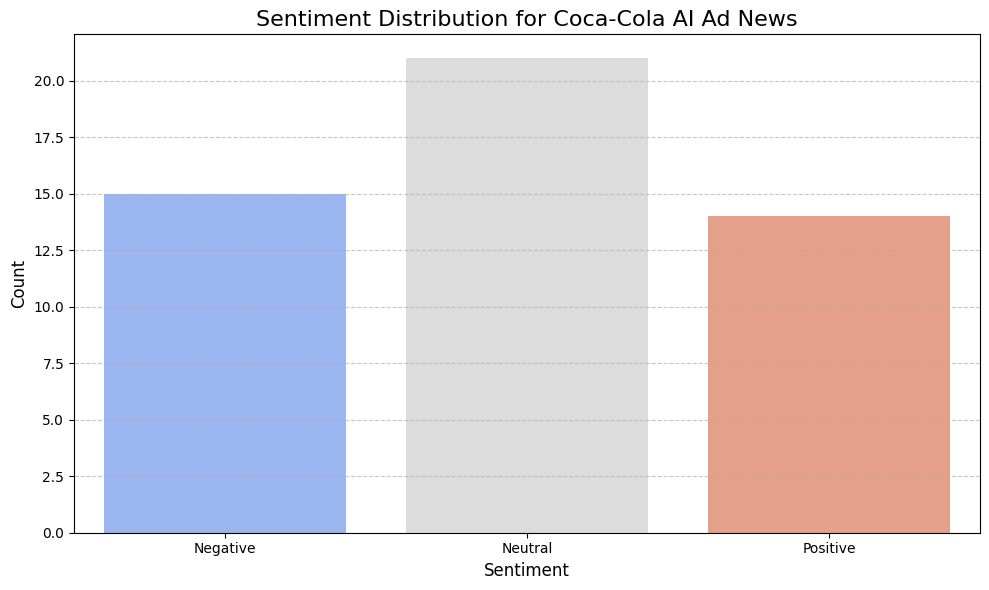

In [ ]:
# Plot sentiment label distribution (count of each sentiment)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', palette='coolwarm', order=['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Distribution for Coca-Cola AI Ad News', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

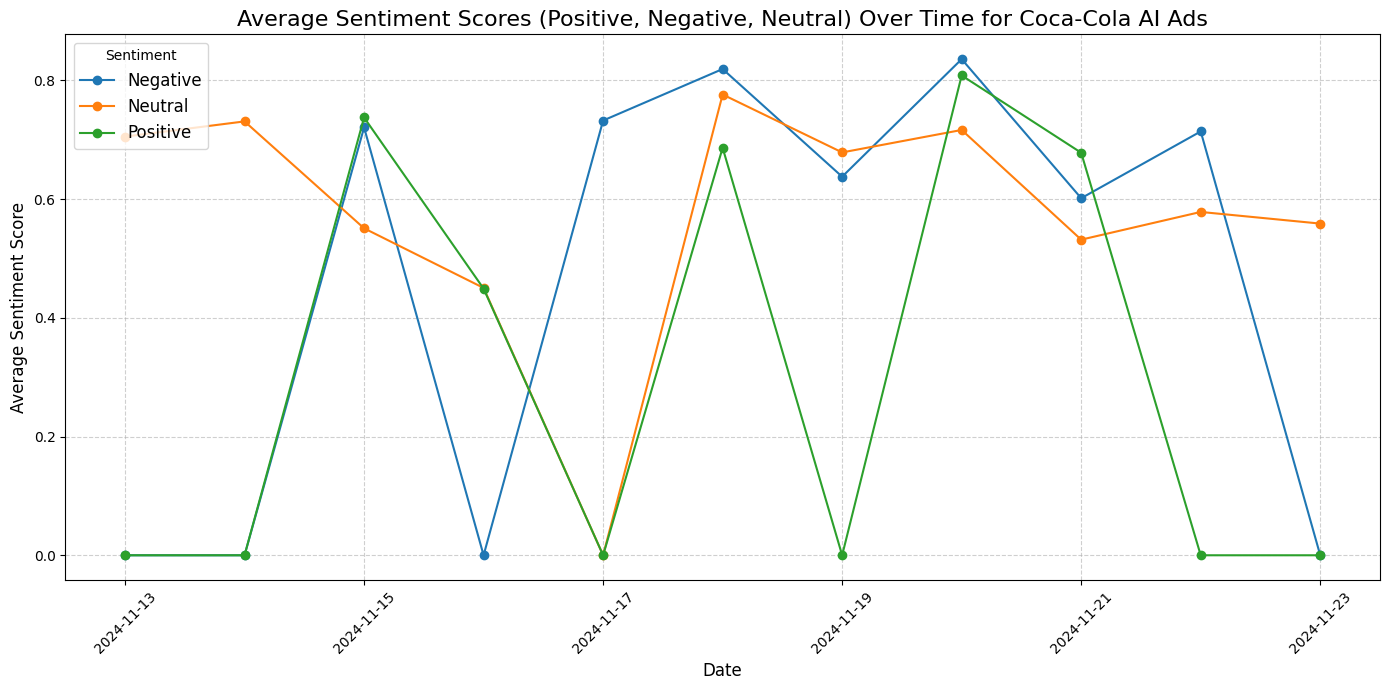

In [ ]:
# Ensure the 'date' column is in datetime format, using 'published_at'
df['date'] = pd.to_datetime(df['published_at'], errors='coerce')

# Extract date part (ignoring time)
df['date'] = df['date'].dt.date

# Group by date and sentiment, and calculate the average sentiment score
average_sentiment_scores = df.groupby(['date', 'sentiment'])['sentiment_score'].mean().unstack(fill_value=0)

# Plot the average sentiment scores over time
plt.figure(figsize=(14, 7))
average_sentiment_scores.plot(kind='line', marker='o', linestyle='-', markersize=6, figsize=(14, 7))
plt.title('Average Sentiment Scores (Positive, Negative, Neutral) Over Time for Coca-Cola AI Ads', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Sentiment', loc='upper left', fontsize=12)
plt.show()


In [ ]:
# Load emotion analysis pipeline
emotion_analyzer = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base')

# Function to analyze emotion
def analyze_emotion(text):
    result = emotion_analyzer(text[:512])  # Limit to 512 characters for compatibility
    emotion = result[0]
    return emotion['label'], emotion['score']

# Perform emotion analysis on the clean_text column
df['emotion'], df['emotion_score'] = zip(*df['clean_text'].map(analyze_emotion))

# Save the results for review
df.to_csv('coca_cola_ai_ad_emotion.csv', index=False)

# Preview the DataFrame
print(df[['clean_text', 'emotion', 'emotion_score']].head())


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

                                          clean_text  emotion  emotion_score
0  New CocaCola Christmas Ad Uses AI Generation C...  neutral       0.427454
1  AI Coke Ad Shows Well Argue About Advertisemen...    anger       0.697909
2  CocaCola Uses AI Video to Reimagine Its Classi...  neutral       0.694212
3  CocaColas AI Holiday Campaign Fails To Engage ...    anger       0.370800
4  I Fed AI Videos into a Deepfake Detector to Se...  neutral       0.893207


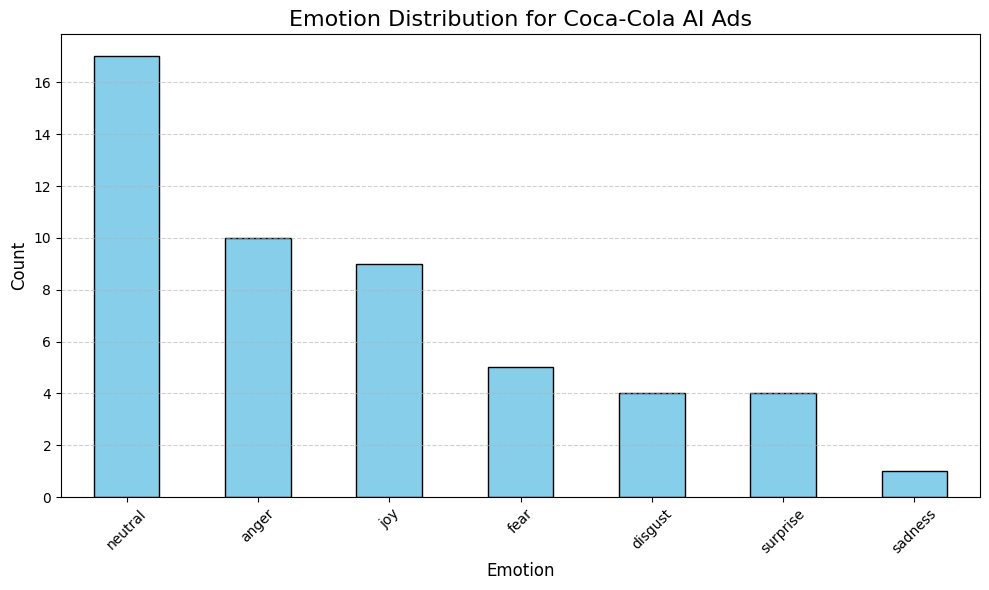

In [ ]:
# Count the occurrences of each emotion
emotion_counts = df['emotion'].value_counts()

# Plot the emotion counts
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Emotion Distribution for Coca-Cola AI Ads', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

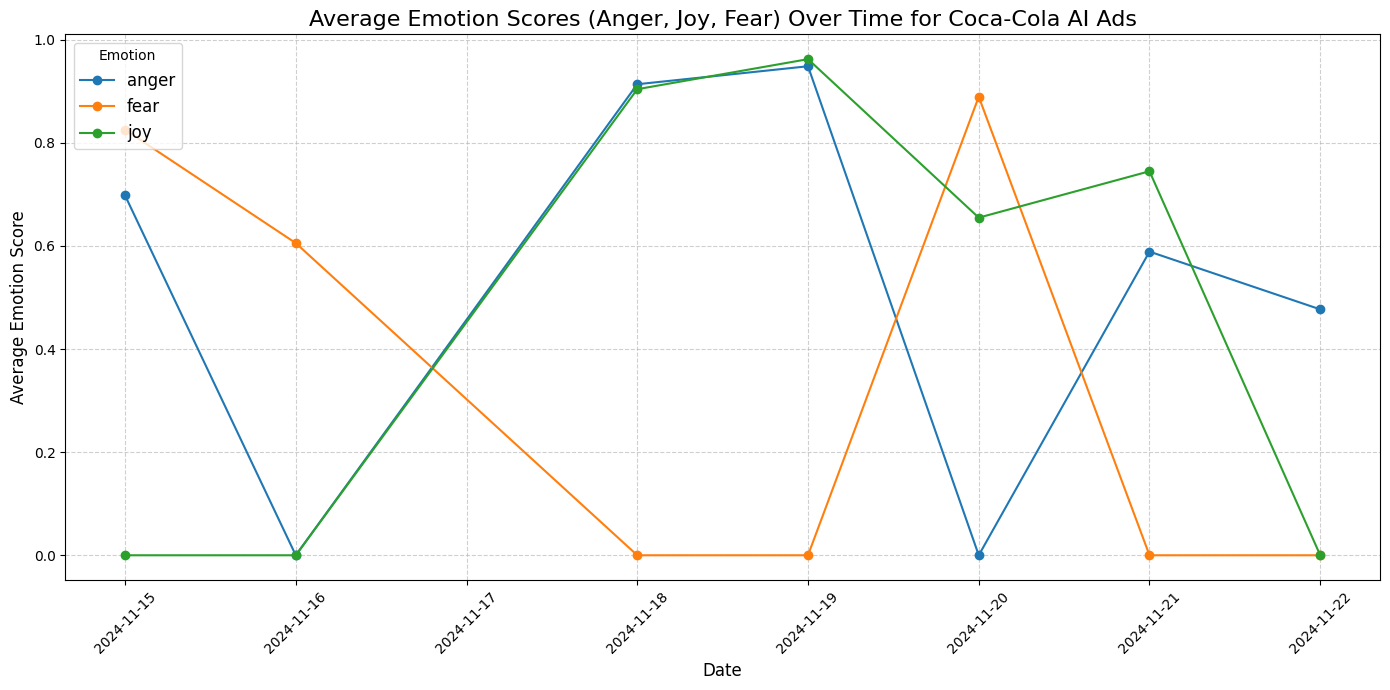

In [ ]:
# Filter the dataframe to include only 'anger', 'joy', and 'fear' emotions
filtered_emotions = df[df['emotion'].isin(['anger', 'joy', 'fear'])]

# Group by date and emotion, and calculate the average emotion score
average_emotion_scores = filtered_emotions.groupby(['date', 'emotion'])['emotion_score'].mean().unstack(fill_value=0)

# Plot the average emotion scores over time
plt.figure(figsize=(14, 7))
average_emotion_scores.plot(kind='line', marker='o', figsize=(14, 7), linestyle='-', markersize=6)
plt.title('Average Emotion Scores (Anger, Joy, Fear) Over Time for Coca-Cola AI Ads', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Emotion Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Emotion', loc='upper left', fontsize=12)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


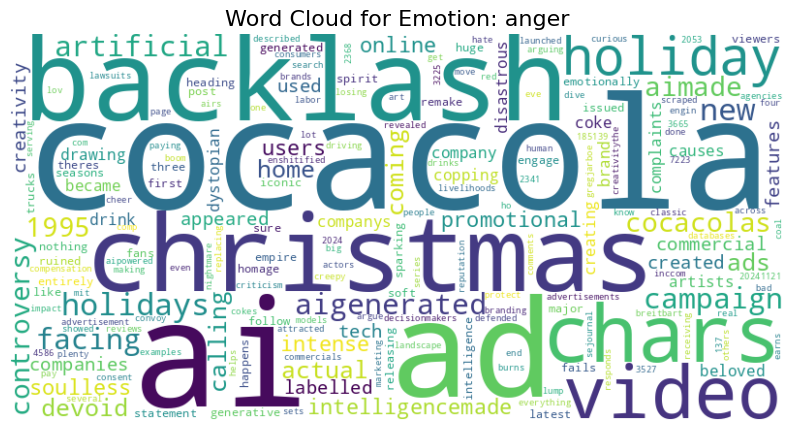

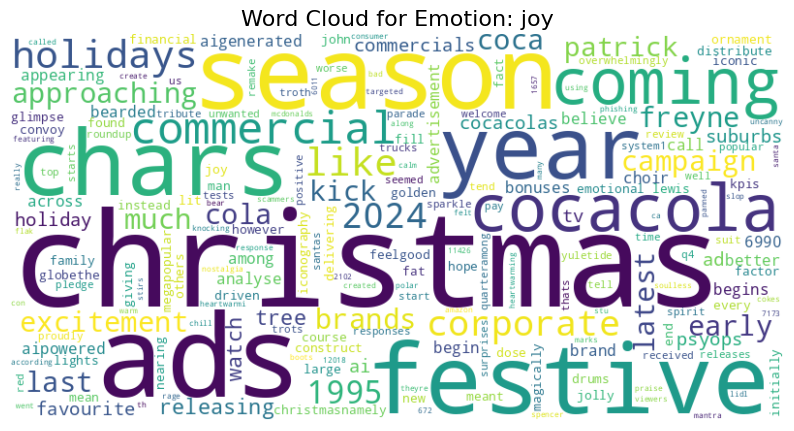

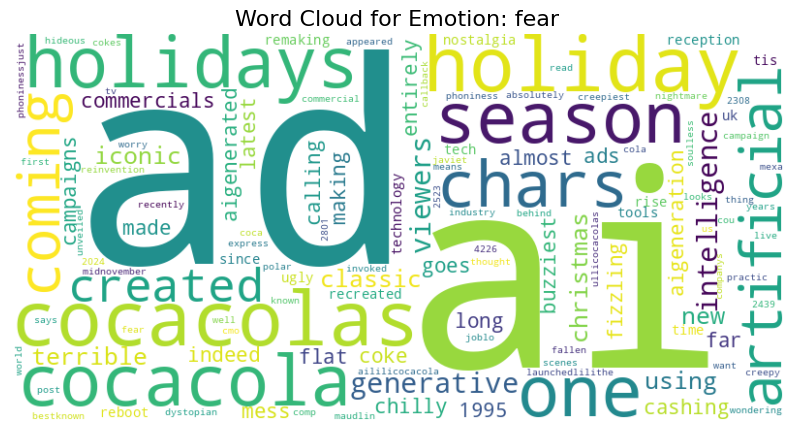

In [ ]:
import nltk
nltk.download('stopwords')

# Define a function to generate word cloud for a given emotion
def plot_wordcloud(emotion, text_data):
    # Set up the CountVectorizer to exclude stopwords
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    # Fit the vectorizer and transform the text
    X = vectorizer.fit_transform(text_data)
    # Sum up the word frequencies
    word_freq = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    # Create a dictionary of words and their frequencies
    word_freq_dict = dict(zip(words, word_freq))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Emotion: {emotion}", fontsize=16)
    plt.show()

# Filter the dataframe to exclude neutral emotions
filtered_emotions = df[df['emotion'] != 'neutral']

# Loop over each emotion and generate the word cloud
for emotion in ['anger', 'joy', 'fear']:
    # Get the text associated with the specific emotion
    emotion_data = filtered_emotions[filtered_emotions['emotion'] == emotion]['clean_text']
    plot_wordcloud(emotion, emotion_data)


In [ ]:
# Function to get the most common bigrams for a given emotion
def extract_bigrams_by_emotion(df, emotion):
    # Filter the data for the specific emotion
    emotion_df = df[df['emotion'] == emotion]

    # Initialize vectorizer to capture common bigrams (pairs of words)
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")

    # Apply vectorizer to extract bigrams
    X = vectorizer.fit_transform(emotion_df['clean_text'])  # Ensure you are using the 'clean_text' column
    bigrams = vectorizer.get_feature_names_out()
    bigram_counts = X.toarray().sum(axis=0)

    # Create a DataFrame to store bigrams and their counts
    bigram_freq_df = pd.DataFrame({'Bigram': bigrams, 'Frequency': bigram_counts})
    bigram_freq_df = bigram_freq_df.sort_values(by='Frequency', ascending=False)

    return bigram_freq_df

# Extract and save the most common bigrams to separate CSV files for each emotion
emotions = ['anger', 'joy', 'fear']

# Loop through each emotion and save the bigrams to a CSV
for emotion in emotions:
    # Extract bigrams for the current emotion
    bigram_freq_df = extract_bigrams_by_emotion(df, emotion)

    # Save the bigrams and their frequencies to a CSV file named after the emotion
    file_name = f'{emotion}_bigrams.csv'
    bigram_freq_df.to_csv(file_name, index=False)  # Save both 'Bigram' and 'Frequency' columns

    # Display the saved CSV content
    print(f"Displaying top bigrams for {emotion.capitalize()} from {file_name}:")
    print(bigram_freq_df.head(40))  # Display top 40 bigrams for review
    print("\n" + "-"*50 + "\n")


Displaying top bigrams for Anger from anger_bigrams.csv:
                          Bigram  Frequency
90                  christmas ad          6
100              cocacola facing          6
1                  1995 holidays          5
192              holidays coming          4
294                  video users          4
63   artificial intelligencemade          4
266              soulless devoid          4
206             intense backlash          4
151                devoid actual          4
70               backlash online          4
83              calling soulless          4
242            promotional video          4
291                users calling          4
92         christmas promotional          4
205   intelligencemade christmas          4
234            online artificial          4
172              facing backlash          4
190             holiday campaign          3
293               video features          3
48         aigenerated christmas          3
53                 

In [ ]:
!pip install xlsxwriter
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# List of file paths for the CSV files
file_paths = [
    "/content/coca_cola_ai_ad_emotion.csv",
    "/content/fear_bigrams.csv",
    "/content/joy_bigrams.csv",
    "/content/anger_bigrams.csv"
]

# Read CSV files
dataframes = [pd.read_csv(file) for file in file_paths]

# Combine the DataFrames
combined_df = pd.concat(dataframes, axis=1)  # Use axis=1 for column-wise or axis=0 for row-wise concatenation

# Save combined DataFrame to a new Excel file
combined_df.to_excel("combined_output.xlsx", index=False, engine='openpyxl')  # Ensure 'openpyxl' is installed

print("Data combined and saved to 'combined_output.xlsx'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data combined and saved to 'combined_output.xlsx'.
